In [1]:
import csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import log
from collections import Counter
from nltk.util import ngrams
import pandas as pd
import plotly.express as px

data = [row for row in csv.DictReader(open('aligned_data.tsv'), delimiter='\t')]

In [3]:
def make_heatmap(M, row_names, col_names, row_tots, col_tots,
                 col_cutoff = 20, row_cutoff = 20, row_scale=0.15, col_scale=0.2, cmap='coolwarm',
                sort = None, annotate=False, saveas=None):
    
    if (row_cutoff is not None) and (col_cutoff is not None):          
        plot_M = M[row_tots>row_cutoff, :][:, col_tots>col_cutoff]
        plot_row = [w for i, w in enumerate(row_names) if row_tots[i] > row_cutoff]
        plot_col = [w for i, w in enumerate(col_names) if col_tots[i] > col_cutoff]
    else:
        plot_M = M
        plot_row = row_names
        plot_col = col_names
        
    if sort == 'diag':
        idxs = np.argmax(plot_M, axis=1) 
        order = np.argsort(idxs)
        sorted_M = plot_M[order]
        plot_M = sorted_M
        plot_row = [plot_row[i] for i in order]
    elif sort == 'strength':
        idxs = np.max(plot_M, axis=1) 
        order = np.flip(np.argsort(idxs))
        sorted_M = plot_M[order]
        plot_M = sorted_M
        plot_row = [plot_row[i] for i in order]
    elif sort == 'row':
        rows = sorted(list(set(plot_row)))
        order = np.argsort([rows.index(n) for n in plot_row])
        sorted_M = plot_M[order]
        plot_M = sorted_M
        plot_row = [plot_row[i] for i in order]
        
    height, width = plot_M.shape
    plt.figure(figsize=(int(round(width*col_scale)), int(round(height*row_scale))))

    if annotate:
        sns.heatmap(plot_M, cmap=cmap, annot=True, fmt=".01f")
    else:
        sns.heatmap(plot_M, cmap=cmap, cbar=False)
    plt.yticks(np.arange(plot_M.shape[0])+0.5, plot_row, rotation=0)
    plt.xticks(np.arange(plot_M.shape[1])+0.5, plot_col, rotation=90)
    if saveas:
        plt.savefig(saveas, bbox_inches='tight')
    plt.show()
    plt.clf()
    
def get_pmi(freq):
    col_tots = np.sum(freq, axis=0)
    row_tots = np.sum(freq, axis=1)
    tot = np.sum(freq)
    
    rows, cols = freq.shape
    PMI = np.zeros((rows, cols))
    for i in range(rows):
        for j in range(cols):
            pmi = (freq[i][j]/tot) / ((row_tots[i]/tot) * (col_tots[j]/tot))
            PMI[i][j] = log(pmi) if pmi > 0 else 0
    return PMI
    
def make_mats(D, POS = 'VERB', window_size=0):
    poslst = POS.split(',')
    zs = sorted(list(set([r['z'] for r in data])), key=lambda e:int(e) if not e == 'NA' else -1)
    words = sorted(list(set([r['lemma'] for r in D if r['pos'] in poslst])))
  
    
    N = len(D)
    freq = np.zeros((len(words), len(zs)))
    straight_count = np.zeros((len(words), len(zs)))
    for i, d in enumerate(D):
        if d['pos'] in poslst:
            w = d['lemma']
            for j in range(max(0, i-window_size), min(i+window_size, N)+1):
                s = D[j]['z']
                freq[words.index(w)][zs.index(s)] += 1
                if i == j:
                    straight_count[words.index(w)][zs.index(s)] += 1
    
    col_tots = np.sum(straight_count, axis=0)
    row_tots = np.sum(straight_count, axis=1)
    PMI = get_pmi(freq)
    return freq, PMI, words, zs, row_tots, col_tots

def make_ngram_mats(D, vocab, K = 3, POS = 'VERB', window_size=0):
    poslst = POS.split(',')
    zs = vocab
    words = sorted(list(set([r['lemma'] for r in D if r['pos'] in poslst])))

    N = len(D)
    freq = np.zeros((len(words), len(zs)))
    straight_count = np.zeros((len(words), len(zs)))
    for i, d in enumerate(D):
        w = d['lemma']
        if d['pos'] in poslst:
            lower = max(0, i-window_size)
            upper = min(i+window_size, N)+1
            for j in range(lower, upper):
                for k in range(K+1):
                    if j+k < len(D):
                        acts = []
                        for idx in range(j, j+k+1):
                            z = get_z(D[idx])
                            acts.append(z)
                        s = ' '.join(acts)
                        if s in zs:
                            freq[words.index(w)][zs.index(s)] += 1
                            if (i == j):
                                straight_count[words.index(w)][zs.index(s)] += 1
    
    col_tots = np.sum(straight_count, axis=0)
    row_tots = np.sum(straight_count, axis=1)
    
    PMI = get_pmi(freq)
    return freq, PMI, words, zs, row_tots, col_tots

def get_z(D):
    z = D['z']
    z += "-" if D["end_obj"] == "None" else "+"
    #z += D["end_obj"]
    return z

In [4]:
seqs = {}
lasts = {}
for d in data:
    p = d['participant']
    t = d['task']
    k = (p,t)
    if k not in seqs:
        seqs[k] = [[], []]
        lasts[k] = [None, None]

    z = get_z(d)
    if not z == lasts[k][0]:
        seqs[k][0].append(z)
        lasts[k][0] = z
        
    w = '%s_%s'%(d['lemma'], d['pos'])
    if not w == lasts[k][1]:
        seqs[k][1].append(w)
        lasts[k][1] = w

In [5]:
vocab = [{}, {}] # actions, words
by_person = [{}, {}] # actions, words
ns = [20, 1]

for k, lsts in seqs.items():
    for i, lst in enumerate(lsts):
        for n in range(ns[i]+1):
            for ngm in ngrams(lst, n):
                w = ' '.join(['%s'%e for e in ngm])
                if w not in vocab[i]:
                    vocab[i][w] = 0
                    by_person[i][w] = set()
                vocab[i][w] += 1
                by_person[i][w].add(k[0])
                
vocab_lsts = [[], []]

for i, v in enumerate(vocab):
    for w, c in sorted(v.items(), key=lambda e:e[1], reverse=True):
        if len(by_person[i][w]) >= 2:
            vocab_lsts[i].append(w)
            
for l in vocab_lsts:
    print(len(l), l[:10])

10148 ['3+', '1+', '5+', '2+', '1+ 3+', '8+', '3+ 1+', '3-', '7+', '2-']
577 ['NA_NA', '-PRON-_PRON', 'be_AUX', 'and_CCONJ', 'the_DET', 'go_VERB', 'to_PART', 'up_ADP', 'put_VERB', 'a_DET']


## Analyze word <-> action alignments

/Users/ellie/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning:

invalid value encountered in double_scalars



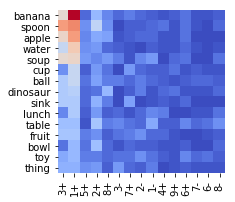

<Figure size 432x288 with 0 Axes>

In [6]:
pos = 'NOUN'

freq, PMI, row_names, col_names, row_tots, col_tots = make_ngram_mats(data, vocab=vocab_lsts[0],
                                                                    POS = pos,
                                                                    window_size=0, K=0)

make_heatmap(freq, row_names, col_names, row_tots, col_tots, col_cutoff=50,
                row_cutoff=50, row_scale=0.2, col_scale=0.2, sort="strength")

## Analyze word instances rather than types

In [7]:
def make_token_mats(D, _vocab, K = 1, window_size = 1, use_objects=True):   
    vocab = [v for v in _vocab if len(v.split()) <= K+1]
    if use_objects:
        objs = list(set([d['end_obj'] for d in D]))
        vocab += objs
    vocabset = set(vocab)
    N = len(D)
    freq = np.zeros((N, len(vocab)))
    lbls = []
    meta = []
    for i, d in enumerate(D):
        start = d['step']
        end = D[i+1]['step'] if i < N-1 else ''
        w = d['lemma']+'_'+d['pos']
        lbls.append(w)
        meta.append(d['participant'] + ' ' + d['task'] + ' ' + '%s-%s'%(start, end))
        lower = max(0, i-window_size)
        upper = min(i+window_size, N)
        for j in range(lower, upper):
            if use_objects:
                o = D[j]['end_obj']
                freq[i][vocab.index(o)] += 1
            for k in range(K+1):
                if j+k < len(D):
                    acts = []
                    for idx in range(j, j+k+1):
                        z = get_z(D[idx])
                        acts.append(z)
                    s = ' '.join(acts)
                    if s in vocabset:
                        freq[i][vocab.index(s)] += 1

    #PMI = get_pmi(freq)
    return freq, lbls, meta, vocab

In [17]:
X, y, meta, vocab = make_token_mats(data, vocab_lsts[0], K = 2,
                                    window_size = 3, use_objects=True)
print(X)
print(X.shape)
print(len(y))
print(meta[:10])

[[0. 0. 0. ... 3. 0. 0.]
 [0. 0. 0. ... 4. 0. 0.]
 [0. 0. 0. ... 5. 0. 0.]
 ...
 [2. 2. 0. ... 0. 0. 0.]
 [2. 2. 0. ... 0. 0. 0.]
 [1. 2. 0. ... 0. 0. 0.]]
(31535, 1328)
31535
['1_1a 1 11808-11814', '1_1a 1 11814-11844', '1_1a 1 11844-11922', '1_1a 1 11922-11952', '1_1a 1 11952-11997', '1_1a 1 11997-12006', '1_1a 1 12006-12060', '1_1a 1 12060-12147', '1_1a 1 12147-12192', '1_1a 1 12192-12204']


In [22]:
#POS = ['VERB']
#top_words = [w for w in vocab_lsts[1] if w.split('_')[1] in POS][:20] 
#top_words = [w for w in vocab_lsts[1]][1:51] 
#top_words = ['play_VERB', 'drink_VERB']
#top_words = ['banana_NOUN', 'spoon_NOUN']
top_words = []
for l in open('../nbc/target_words.txt').readlines():
    pos, w = l.strip().split('\t')
    if pos == 'VERB':
        top_words.append('%s_%s'%(w, pos))
#top_words = top_words[:5]
print(top_words)

is_top = [yy in top_words for yy in y]
X_plot = X[is_top, :]
y_plot = np.array(y)[is_top]
m_plot = np.array(meta)[is_top]
print(X_plot.shape)
#print(y_plot)
#print(m_plot)

['pick_VERB', 'put_VERB', 'push_VERB', 'get_VERB', 'drop_VERB', 'throw_VERB', 'hold_VERB', 'open_VERB', 'close_VERB', 'give_VERB', 'go_VERB', 'shake_VERB', 'take_VERB', 'eat_VERB', 'wash_VERB', 'play_VERB', 'walk_VERB', 'cook_VERB', 'stop_VERB']
(1347, 1328)


In [23]:
rowcount = np.array([list(y_plot).count(l) for l in y_plot])
print(rowcount.shape)
colcount = np.sum(X_plot, axis=0)
print(colcount.shape)

#make_heatmap(X_plot, y_plot, vocab, rowcount, colcount, col_cutoff=0,
#                row_cutoff=0, row_scale=0.2, col_scale=0.2, sort="row", cmap="binary") #, saveas="banana-spoon.pdf")

(1347,)
(1328,)


In [25]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

#reducer = TruncatedSVD(n_components=2)
reducer = TSNE(n_components=2)

red = reducer.fit_transform(X_plot, y_plot)

In [21]:
lemmas = [y.split('_')[0] for y in y_plot]
pos = [y.split('_')[1] for y in y_plot]
ps = [y.split(' ')[0] for y in m_plot]
ts = [y.split(' ')[1] for y in m_plot]
pts = [y.rsplit(' ', 1)[0] for y in m_plot]
steps = [y.split(' ')[2] for y in m_plot]

ddict = {'x': red[:,0], 'y': red[:,1], 'lemma': lemmas, 'pos': pos,
         'lemmapos': y_plot, 'participant': ps, 'task': ts, 'pt': pts, 'step': steps}

top_feat = [vocab[i] for i in np.argmax(X_plot, axis=1)]
ddict['top'] = top_feat
#for i in range(len(vocab)):
#    ddict[vocab[i]] = X_plot[:, i]
    
feats = ['participant', 'top', 'step', 'pt'] #ddict.keys()

if red.shape[1] == 3:
    ddict['z'] = red[:,2]
    d = pd.DataFrame.from_dict(ddict)
    fig = px.scatter_3d(d, x="x", y="y", z="z", color='lemma',
                 hover_data=feats)
else:
    d = pd.DataFrame.from_dict(ddict)
    fig = px.scatter(d, x="x", y="y", color='lemma', hover_data=feats,
                    color_discrete_sequence=px.colors.qualitative.Light24)
fig.write_image("verb-n2-obj.pdf")
fig.show()

## Graveyard

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

freq, PMI, row_names, col_names, row_tots, col_tots = make_ngram_mats(data, vocab=vocab_lst,
                                                                    POS = "VERB",
                                                                    window_size=3)
#svd = TruncatedSVD(n_components=2, n_iter=20)
#red = svd.fit_transform(PMI)
tsne = TSNE(n_components=2)
red = tsne.fit_transform(freq)

In [ ]:
top_verbs = [w for w,c in sorted(words["VERB"].items(), key=lambda e:e[1], reverse=True)][:50]
plt.figure(figsize=(20,10))
plt.scatter(red[:,0], red[:,1], alpha=0.5)
for i in range(len(row_names)):
    if row_names[i] in top_verbs:
        x, y = red[i,:]
        plt.annotate(row_names[i], xy=(x,y), ha="center", va="center", fontsize="x-large")
plt.show()

In [ ]:
for pos in ['VERB']: #, 'NOUN']:
    freq, PMI, row_names, col_names, row_tots, col_tots = make_mats(data,
                                                                    POS = pos,
                                                                    window_size=3)
    make_heatmap(freq, row_names, col_names, row_tots, col_tots, CUTOFF=100)
    make_heatmap(PMI, row_names, col_names, row_tots, col_tots, CUTOFF=100)

## Analyze action frequencies and co-occurences

In [ ]:
zs = sorted(list(set([r['z'] for r in data])))
print(len(zs), zs)

seqs = {}
lasts = {}
for d in data:
    p = d['participant']
    t = d['task']
    k = (p,t)
    if k not in seqs:
        seqs[k] = []
        lasts[k] = None
    if d['z'] == 'NA':
        continue
    z = int(d['z'])
    if not z == lasts[k]:
        seqs[k].append(z)
        lasts[k] = z
    
lbls = [k for k in seqs]
plt.hist([seqs[k] for k in lbls], bins=len(zs)-1, label=lbls)
plt.xticks(np.arange(len(zs))+1.5, np.arange(len(zs)))
#plt.legend()
plt.show()

In [ ]:
zs = sorted(list(set([r['z'] for r in data])), key=lambda e:int(e) if not e == 'NA' else -1)
people = sorted(list(set([r['participant'] for r in data])))
tasks = sorted(list(set([r['task'] for r in data])))
pts = sorted(list(set([r['participant']+'_'+r['task'] for r in data])))

z_by_p = np.zeros((len(people), len(zs)))
z_by_t = np.zeros((len(tasks), len(zs)))
z_by_pt = np.zeros((len(pts), len(zs)))

for i, d in enumerate(data):
    p = d['participant']
    t = d['task']
    pt = '%s_%s'%(p, t)
    z = d['z']
    z_by_p[people.index(p)][zs.index(z)] += 1
    z_by_t[tasks.index(t)][zs.index(z)] += 1
    z_by_pt[pts.index(pt)][zs.index(z)] += 1
        
make_heatmap(z_by_p, people, zs, np.sum(z_by_p, axis=1), np.sum(z_by_p, axis=0),
             CUTOFF = 0, col_scale = 0.3)
make_heatmap(z_by_t, tasks, zs, np.sum(z_by_t, axis=1), np.sum(z_by_t, axis=0),
             CUTOFF = 0, col_scale = 0.3)
make_heatmap(z_by_pt, pts, zs, np.sum(z_by_pt, axis=1), np.sum(z_by_pt, axis=0),
             CUTOFF = 0, col_scale = 0.3, row_scale=0.2)

In [ ]:
zs = sorted(list(set([r['z'] for r in data])), key=lambda e:int(e) if not e == 'NA' else -1)
W = 1

z_by_z = np.zeros((len(zs), len(zs)))

for k in seqs:
    lst = seqs[k]
    for i in range(len(lst)):
        for j in range(max(0, i-W), min(i+W, N)):
            if not i == j:
                z_by_z[zs.index('%s'%lst[i])][zs.index('%s'%lst[j])] += 1
        
pmi = get_pmi(z_by_z)
make_heatmap(pmi, zs, zs, np.sum(z_by_z, axis=1), np.sum(z_by_z, axis=0),
             CUTOFF = 10, col_scale = 0.5, row_scale=0.5)

make_heatmap(z_by_z, zs, zs, np.sum(z_by_z, axis=1), np.sum(z_by_z, axis=0),
             CUTOFF = 10, col_scale = 0.5, row_scale=0.5, cmap='Blues')

logged = np.log10(z_by_z)
logged[np.isinf(logged)] = 0
make_heatmap(logged, zs, zs, np.sum(z_by_z, axis=1), np.sum(z_by_z, axis=0),
             CUTOFF = 10, col_scale = 0.5, row_scale=0.5, cmap='Blues')